# Implementing Chromagram and Chordgram

Described in [Bachelor Thesis: Design and Evaluation of a Simple Chord Detection Algorithm](https://www.fim.uni-passau.de/fileadmin/dokumente/fakultaeten/fim/lehrstuhl/sauer/geyer/BA_MA_Arbeiten/BA-HausnerChristoph-201409.pdf) by Christoph Hausner.

## The algorithm:

<img src='thealgorithm.png' width='450' />

Some notes from the paper:

* They use sampling rate = 48000 Hz (we're going to use 44100 Hz).
* NFFT = 16384 with overlap factor O = 8 (then, NSTEP = 2048).

In [7]:
## IMPORTS

import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
import librosa
import librosa.display
import scipy
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (20, 6) # set default size of plots
plt.rcParams.update({'font.size': 16})

### LOAD AUDIO

In [8]:
file_path = '../mp3/chords/C.mp3'
samples, fs = librosa.load(file_path, sr = None, offset = 0.0, duration = None)

print('Audio loaded. Duration %.2f seconds - Samples %d - Sampling rate (fs) %d Hz' %
      (len(samples)/fs, len(samples), fs))

Audio(file_path)

Audio loaded. Duration 2.25 seconds - Samples 99072 - Sampling rate (fs) 44100 Hz


### COMPUTE SPECTROGRAM

In [9]:
NFFT = 4096 #16384
OVERLAP_FACTOR = 8
NOVERLAP = 0# NFFT//OVERLAP_FACTOR

f, t, sp = scipy.signal.spectrogram(x=samples, fs=fs, nfft=NFFT, noverlap=NOVERLAP, nperseg=NFFT, 
                                    mode='magnitude', scaling='spectrum')

print('Spectrogram computed. Frequency bins %d, time segments %d.' % sp.shape)

Spectrogram computed. Frequency bins 2049, time segments 24.


### VISUALIZATION

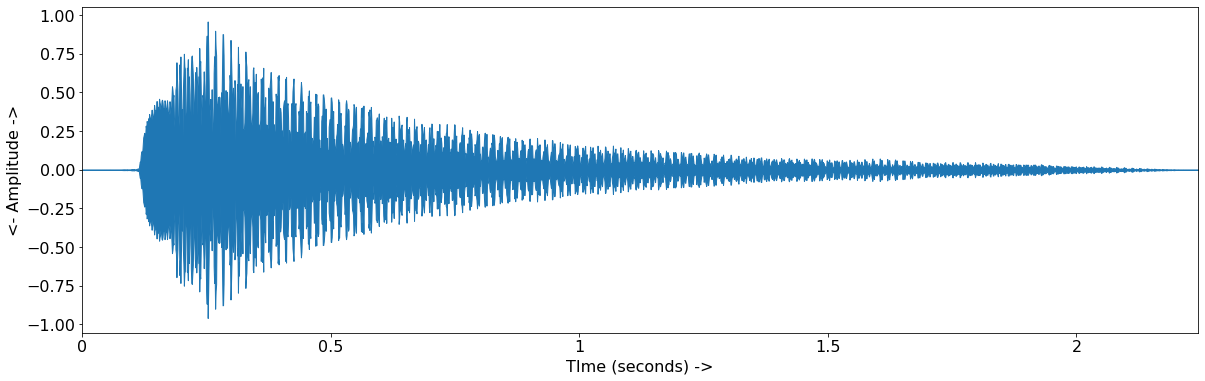

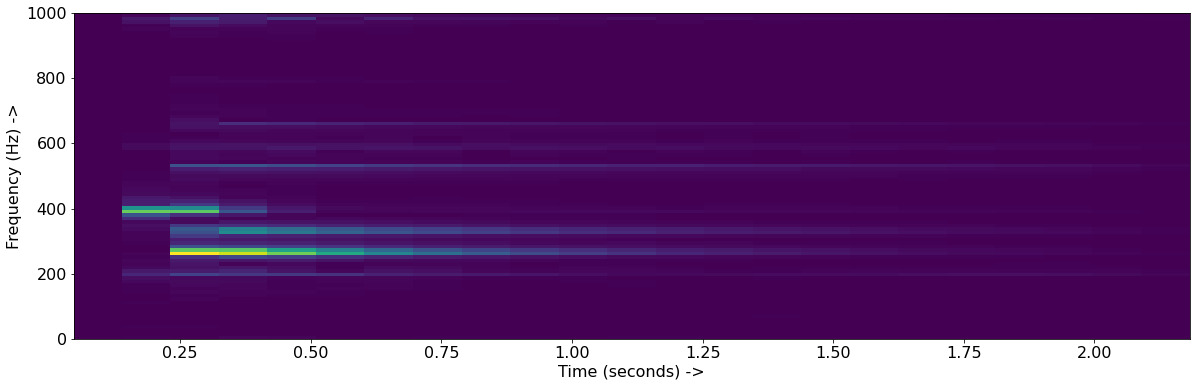

In [10]:
plt.figure()
librosa.display.waveplot(y = samples, sr = fs)
plt.xlabel('TIme (seconds) ->')
plt.ylabel('<- Amplitude ->')
plt.show()

fmax = 1000
idx = (np.abs(f - fmax)).argmin()
plt.pcolormesh(t, f[:idx+1], sp[:idx+1,:])
plt.ylabel('Frequency (Hz) ->')
plt.xlabel('Time (seconds) ->')
plt.show()

### HARMONIC CONTENT EXTRACTION

Harmonic amplitude decay model

<img src='hadm.png' width='200'/>

Harmonic content extraction process

<img src='hce.png' width='450' />

In [139]:
n_harmonics = 5 # number of harmonics to filter
ex = 0.4 # exponent for harmonics amplitude decay model

# harmonics decay model
A = [1.0]
for i in range(n_harmonics):
    A.append(A[0]*(ex**(i+1)))

In [140]:
def harmonic_content_extraction(sp, f, n_harmonics = 10, fmin = 50, fmax = 1000, ex = 0.4):
    sp_filtered = np.full_like(sp, 0)
    flim = f[-1]
    
    for i in range(len(f)):
        if f[i]<fmin:
            continue
        if f[i]>fmax:
            break
        sp_in_hamronics = []
        for n in range(1, n_harmonics):
            if n*f[i] < flim:
                idx = (np.abs(f - n*f[i])).argmin()
                sp_in_hamronics.append(sp[idx,:]*((1/ex)**(n-1)))
        sp_in_hamronics = np.array(sp_in_hamronics)
        sp_filtered[i,:] = np.min(sp_in_hamronics, axis=0)
    return sp_filtered

In [141]:
A2 = []
for i in range(1, 10):
    A2.append((1/ex)**(i-1))

In [142]:
A2

[1.0,
 2.5,
 6.25,
 15.625,
 39.0625,
 97.65625,
 244.140625,
 610.3515625,
 1525.87890625]

In [143]:
sp_filtered = harmonic_content_extraction(sp, f, n_harmonics=n_harmonics, ex=ex)

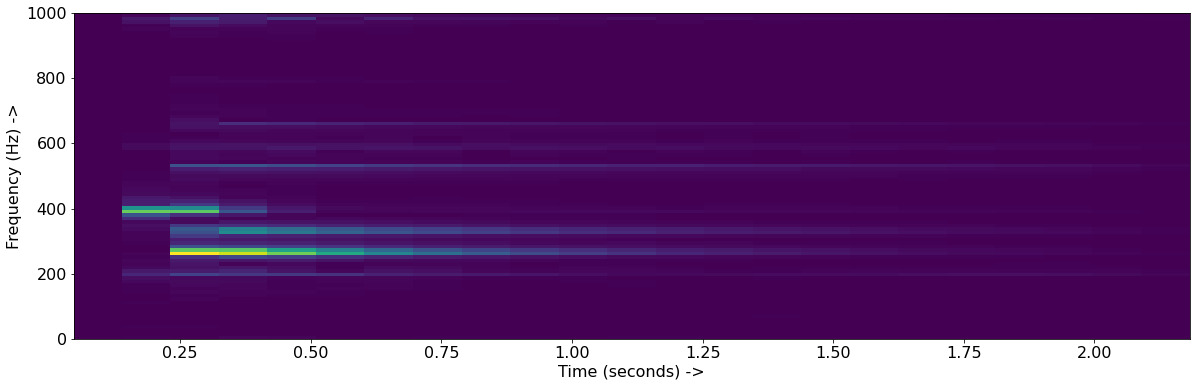

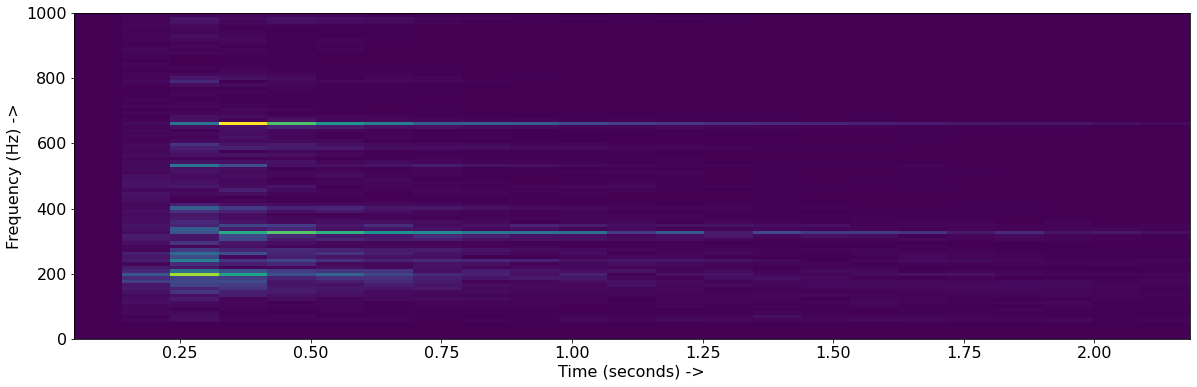

In [144]:
## VISUALIZATION OF ORIGINAL AND FILTERED SPECROGRAMS

fmax = 1000
idx = (np.abs(f - fmax)).argmin()
plt.pcolormesh(t, f[:idx+1], sp[:idx+1,:])
plt.ylabel('Frequency (Hz) ->')
plt.xlabel('Time (seconds) ->')
plt.show()
plt.pcolormesh(t, f[:idx+1], sp_filtered[:idx+1,:])
plt.ylabel('Frequency (Hz) ->')
plt.xlabel('Time (seconds) ->')
plt.show()

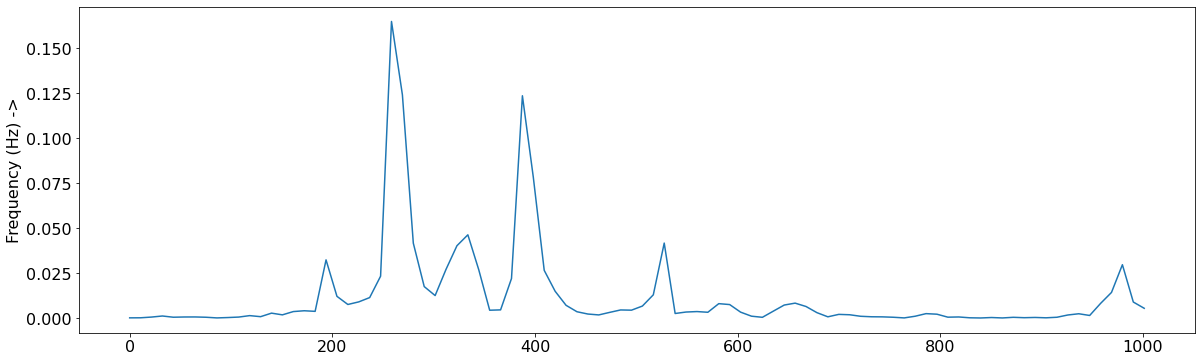

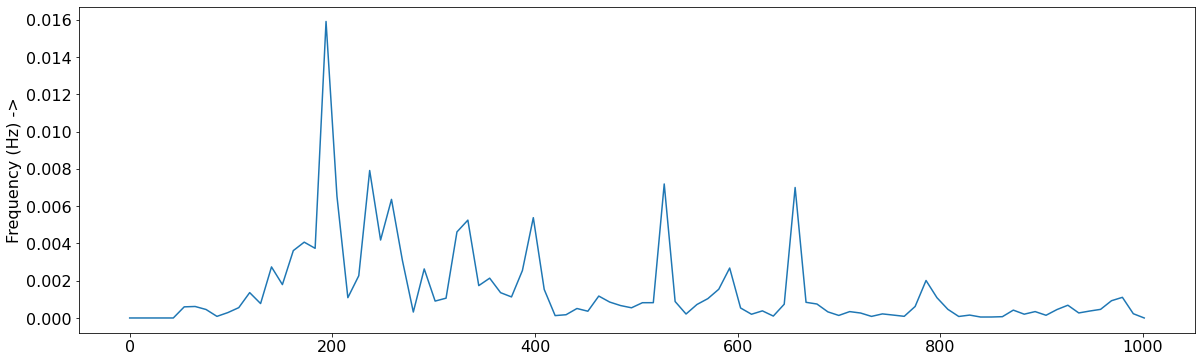

In [145]:
## VISUALIZATION OF ORIGINAL AND FILTERED SPECROGRAMS

fmax = 1000
idx = (np.abs(f - fmax)).argmin()
plt.plot(f[:idx+1], sp[:idx+1,2])
plt.ylabel('Frequency (Hz) ->')
plt.show()
plt.plot(f[:idx+1], sp_filtered[:idx+1,2])
plt.ylabel('Frequency (Hz) ->')
plt.show()

### TUNING ESTIMATION

In [146]:
## not necessary

### CHROMAGRAM CALCULATION

* These are, just like spectrograms, two-dimensional structures where one dimension represents time and the other dimension represents 12-dimensional vectors called chroma vectors whose elements correspond to the 12 pitch classes.
* Each detected note is assigned to one of these pitch classes (the one that describes its relative pitch ignoring octave position.
* Proposed method computes chromagram between D2 and B6, but in our case, considering notes in 3 strings loog guitars, we're going to use the interval G3 to G5.

_Note: in midi notation, G3 is 55 and G5 is G5 is 79._

The chromagram computation can be thought of happening in two steps. First, all frequencies that correspond to a note between Nl and Nh are picked out from the filtered spectrogram (e.g. frequencies of C2, C#2, D2, ..., B6). Then, their respective amplitudes are determined and averaged over all octaves (average of C2, C3, ..., C6, etc.). The result is a chroma vector with 12 elements for each time step.

In [147]:
first_note = 55 # G3  (40 is E2) 
last_note = 79 # G5

In [148]:
def compute_chromagram(sp, f, first_note = 55, last_note = 79, f_A4 = 440):
    
    # método para calcular la frecuencia de las notas en función
    # de su índice en MIDI.
    def freq_midi(N, f_A4=440):
        return 2**((N-69)/12) * f_A4

    # este vector va a guardar 12 valores que corresponden a la energía
    # presente en cada una de las notas
    chromagram = np.zeros((12, sp.shape[1]))
    
    # orden de notas que estoy usando
    pitches = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    # índice midi inicial para cada nota (octava 1)
    midi_codes_zero = [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]
    
    for i in range(12): # para cada nota de las 12 en pitches
        pitch = pitches[i]
        # me trtaigo el primer índice midi de esa nota (por ejemplo, 24 para C)
        midi_code = midi_codes_zero[i]
        # inicializo un array vacío para guardar los valores de energía 
        # en cada octava de la nota en cuestión
        sp_in_note = []
        
        for j in range(10): # para cada octava (este número 10 puede ser variable, 5 es suficiente)
            # chequeo que la nota en la octava j esté en el rango de interés 
            # <midi_code + j*12> es el índice de la nota dada por <midi_code> en la octava <j>
            if midi_code + j*12 < first_note:
                continue
            if midi_code + j*12 > last_note:
                break
            
            # buscar el la posición del valor más parecido a la frecuencia de la nota en la que estoy parado
            # (cuyo número midi es <midi_code + j*12>) en el vector f (vector de frecuencias)
            idx = (np.abs(f - freq_midi(midi_code + j*12))).argmin() 
            # guardo el valor del espectro (b) en el vector vacío 
            sp_in_note.append(sp[idx,:])
            
        # por último (para cada denominación de nota, 12 veces) calculo el promedio de la energía en 
        # todas las octavas que acumulé en el proceso previo.
        sp_in_note = np.array(sp_in_note)
        # lo guardo en la i-ésima posición del vector de 12 lugares que inicialicé al principio
        chromagram[i, :] = np.mean(sp_in_note, axis=0)
        
    return chromagram

In [156]:
chromagram = compute_chromagram(sp, f)

print(chromagram[:,0])

[7.06853389e-05 2.97272891e-05 2.78689640e-05 2.64276950e-05
 5.83463952e-06 1.74422985e-05 2.68562271e-05 4.06095351e-05
 2.88426327e-05 2.37422464e-05 2.59393091e-05 4.61849449e-05]


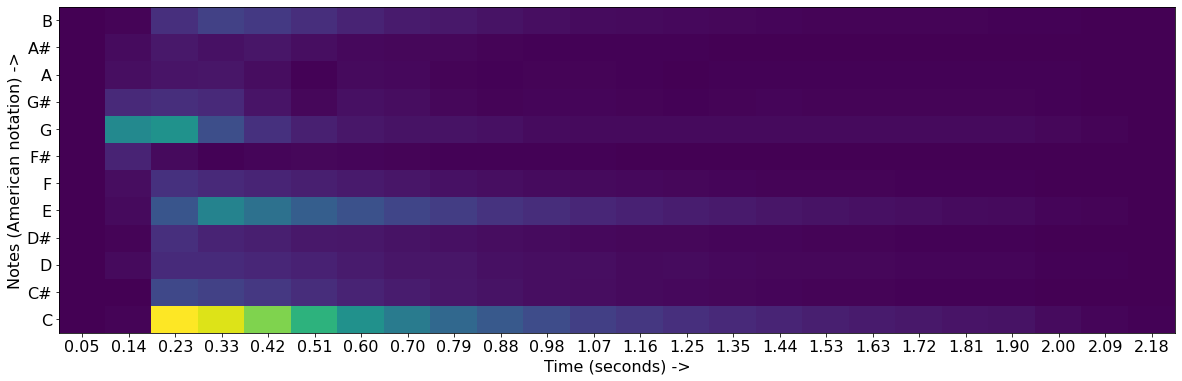

In [157]:
## CHROMAGRAM VISUALIZATION
pitches = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
plt.pcolormesh(chromagram)
plt.yticks(np.arange(len(pitches)) + 0.5, pitches)
plt.xticks(np.arange(len(t)) + 0.5, ['%.2f' % x for x in t])
plt.ylabel('Notes (American notation) ->')
plt.xlabel('Time (seconds) ->')
plt.show()

### CHORDGRAM CALCULATION

Having reduced the input to a series of chroma vectors, the next step is to derive chord probabilities from them.

* First, we define the set of chords that our algorithm can detect, all 24 major and minor chords and a symbol for “no chord”.
* For each chroma vector in the chromagram and for each of these detectable chords a score is computed that expresses how likely it is that the chord is correct.

_Note: we're not using modified chord templates to detect major 7th or minor 7th chords._

In [158]:
## CHORDS TEMPLATES DEFINITION
chords = ['C', 'Cm', 'C#', 'C#m', 'D', 'Dm', 'D#', 'D#m', 'E', 'Em', 'F', 'Fm', 'F#', 'F#m',
          'G', 'Gm', 'G#', 'G#m', 'A', 'Am', 'A#', 'A#m', 'B', 'Bm', 'NC']
chord_templates = [
    [1,0,0,0,1,0,0,1,0,0,0,0],
    [1,0,0,1,0,0,0,1,0,0,0,0],
    [0,1,0,0,0,1,0,0,1,0,0,0],
    [0,1,0,0,1,0,0,0,1,0,0,0],
    [0,0,1,0,0,0,1,0,0,1,0,0],
    [0,0,1,0,0,1,0,0,0,1,0,0],
    [0,0,0,1,0,0,0,1,0,0,1,0],
    [0,0,0,1,0,0,1,0,0,0,1,0],
    [0,0,0,0,1,0,0,0,1,0,0,1],
    [0,0,0,0,1,0,0,1,0,0,0,1],
    [1,0,0,0,0,1,0,0,0,1,0,0],
    [1,0,0,0,0,1,0,0,1,0,0,0],
    [0,1,0,0,0,0,1,0,0,0,1,0],
    [0,1,0,0,0,0,1,0,0,1,0,0],
    [0,0,1,0,0,0,0,1,0,0,0,1],
    [0,0,1,0,0,0,0,1,0,0,1,0],
    [1,0,0,1,0,0,0,0,1,0,0,0],
    [0,0,0,1,0,0,0,0,1,0,0,1],
    [0,1,0,0,1,0,0,0,0,1,0,0],
    [1,0,0,0,1,0,0,0,0,1,0,0],
    [0,0,1,0,0,1,0,0,0,0,1,0],
    [0,1,0,0,0,1,0,0,0,0,1,0],
    [0,0,0,1,0,0,1,0,0,0,0,1],
    [0,0,1,0,0,0,1,0,0,0,0,1],
    [1,1,1,1,1,1,1,1,1,1,1,1]
]
chord_templates = np.array(chord_templates)

In [159]:
def compute_chordgram(chromagram, w_major = 1.0, w_minor = 1.0, w_nc = 0.7):
    chordgram = np.zeros((25,chromagram.shape[1]))
    detected_chords = []
    for i in range(chromagram.shape[1]):
        chroma = chromagram[:,i]
        for j in range(25):
            a = chroma
            b = chord_templates[j]
            chordgram[j,i] = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
        detected_chords.append(chords[chordgram[:,i].argmax()])
    return chordgram, detected_chords

In [160]:
chordgram, detected_chords = compute_chordgram(chromagram)

print(detected_chords)

['NC', 'Gm', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C', 'C']


In [161]:
print(t)

[0.04643991 0.13931973 0.23219955 0.32507937 0.41795918 0.510839
 0.60371882 0.69659864 0.78947846 0.88235828 0.9752381  1.06811791
 1.16099773 1.25387755 1.34675737 1.43963719 1.53251701 1.62539683
 1.71827664 1.81115646 1.90403628 1.9969161  2.08979592 2.18267574]


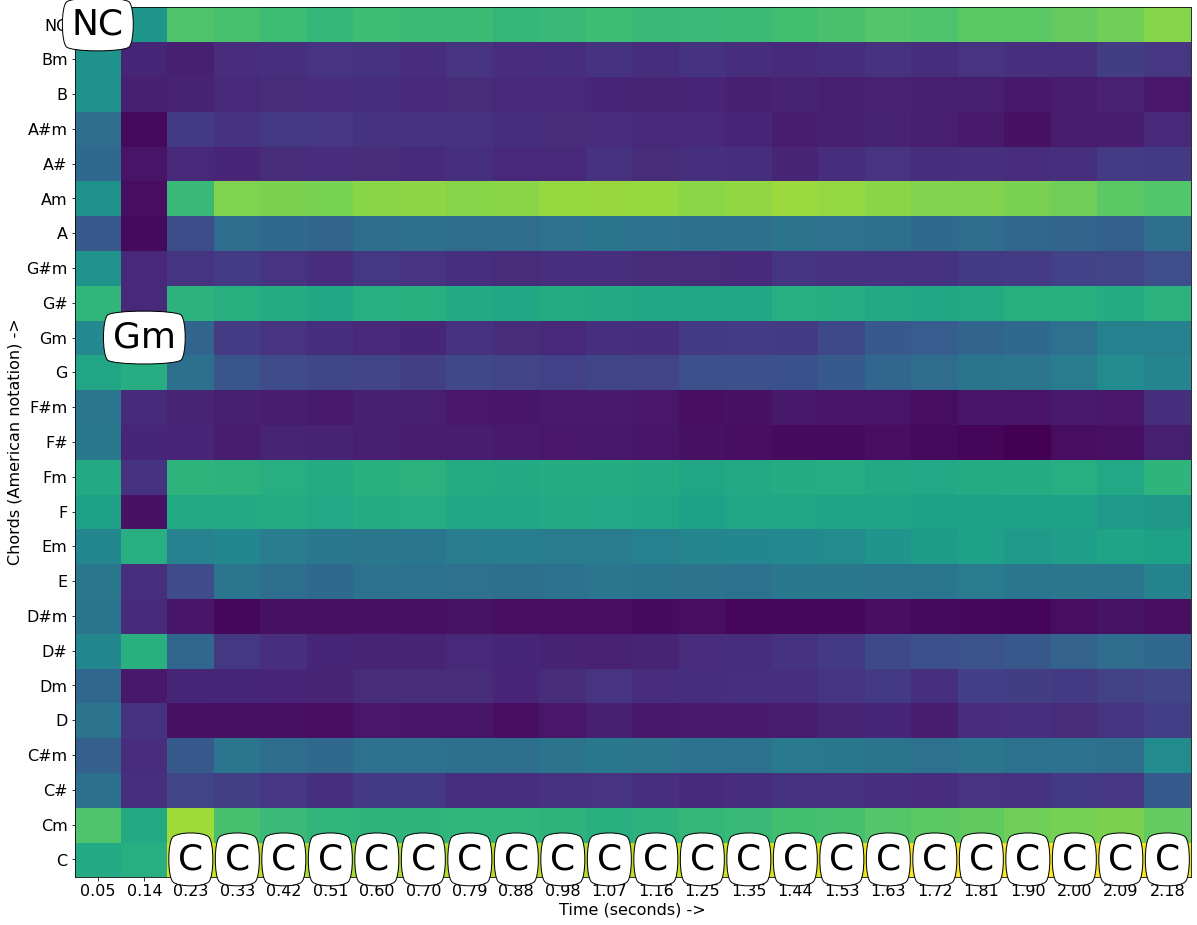

In [162]:
## CHORDGRAM VISUALIZATION
# plt.figure(figsize=[20,16])
fig, ax = plt.subplots(figsize=(20, 16))
ax.pcolormesh(chordgram)
plt.yticks(np.arange(len(chords)) + 0.5, chords)
plt.xticks(np.arange(len(t)) + 0.5, ['%.2f' % x for x in t])
plt.ylabel('Chords (American notation) ->')
plt.xlabel('Time (seconds) ->')

# annotate with detected chords
bbox_props = dict(boxstyle="round4", fc="white", ec="black")
tt = np.arange(len(t)) + 0.5
for i in range(len(t)):
    ax.text(tt[i], chords.index(detected_chords[i]) + 0.5, detected_chords[i], 
            size=36, bbox=bbox_props, ha="center", va="center")
plt.show()